In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
from cellpose import models, io, core
import time
from sklearn.model_selection import train_test_split
from statistics import mean
import torch
from ptflops import get_model_complexity_info

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = models.CellposeModel(gpu=core.use_gpu(), model_type='cyto', device=torch.device('cuda:0'))

In [5]:
unet = models.UnetModel(gpu=core.use_gpu()).net

In [16]:
input_size = (2, 224, 224) 
flops, params = get_model_complexity_info(unet, input_size)

CPnet(
  3.97 M, 100.000% Params, 9.59 GMac, 100.000% MACs, 
  (downsample): downsample(
    1.17 M, 29.570% Params, 2.59 GMac, 27.045% MACs, 
    (down): Sequential(
      1.17 M, 29.570% Params, 2.59 GMac, 27.015% MACs, 
      (conv_down_0): convdown(
        9.92 k, 0.250% Params, 499.65 MMac, 5.212% MACs, 
        (conv): Sequential(
          9.92 k, 0.250% Params, 499.65 MMac, 5.212% MACs, 
          (conv_0): Sequential(
            612, 0.015% Params, 30.81 MMac, 0.321% MACs, 
            (0): BatchNorm2d(4, 0.000% Params, 200.7 KMac, 0.002% MACs, 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(0, 0.000% Params, 100.35 KMac, 0.001% MACs, inplace=True)
            (2): Conv2d(608, 0.015% Params, 30.51 MMac, 0.318% MACs, 2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_1): Sequential(
            9.31 k, 0.235% Params, 468.84 MMac, 4.891% MACs, 
            (0): BatchNorm2d(64, 0.002% Params, 3.21 MMac,

In [18]:
with torch.cuda.device(0):
  net = models.UnetModel(gpu=core.use_gpu()).net
  macs, params = get_model_complexity_info(net, (2, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

CPnet(
  3.97 M, 100.000% Params, 9.59 GMac, 100.000% MACs, 
  (downsample): downsample(
    1.17 M, 29.570% Params, 2.59 GMac, 27.045% MACs, 
    (down): Sequential(
      1.17 M, 29.570% Params, 2.59 GMac, 27.015% MACs, 
      (conv_down_0): convdown(
        9.92 k, 0.250% Params, 499.65 MMac, 5.212% MACs, 
        (conv): Sequential(
          9.92 k, 0.250% Params, 499.65 MMac, 5.212% MACs, 
          (conv_0): Sequential(
            612, 0.015% Params, 30.81 MMac, 0.321% MACs, 
            (0): BatchNorm2d(4, 0.000% Params, 200.7 KMac, 0.002% MACs, 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(0, 0.000% Params, 100.35 KMac, 0.001% MACs, inplace=True)
            (2): Conv2d(608, 0.015% Params, 30.51 MMac, 0.318% MACs, 2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_1): Sequential(
            9.31 k, 0.235% Params, 468.84 MMac, 4.891% MACs, 
            (0): BatchNorm2d(64, 0.002% Params, 3.21 MMac,

In [138]:
#import the trained cellpose_model
cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model="c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\cellpose_trained_model_SIM_3")
cellpose_model_net = cellpose_model.net
isinstance(cellpose_model_net, torch.nn.Module)

with torch.cuda.device(0):
  net = cellpose_model_net
  macs, params = get_model_complexity_info(net, (2, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

CPnet(
  6.6 M, 100.000% Params, 15.63 GMac, 100.000% MACs, 
  (downsample): downsample(
    2.79 M, 42.222% Params, 6.4 GMac, 40.943% MACs, 
    (down): Sequential(
      2.79 M, 42.222% Params, 6.4 GMac, 40.925% MACs, 
      (res_down_0): resdown(
        28.65 k, 0.434% Params, 1.44 GMac, 9.226% MACs, 
        (conv): Sequential(
          28.55 k, 0.432% Params, 1.44 GMac, 9.194% MACs, 
          (conv_0): Sequential(
            612, 0.009% Params, 30.81 MMac, 0.197% MACs, 
            (0): BatchNorm2d(4, 0.000% Params, 200.7 KMac, 0.001% MACs, 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(0, 0.000% Params, 100.35 KMac, 0.001% MACs, inplace=True)
            (2): Conv2d(608, 0.009% Params, 30.51 MMac, 0.195% MACs, 2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_1): Sequential(
            9.31 k, 0.141% Params, 468.84 MMac, 2.999% MACs, 
            (0): BatchNorm2d(64, 0.001% Params, 3.21 MMac, 0.021

(773, 739)


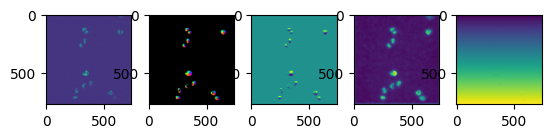

In [216]:
image = X_train[0]
plt.subplot(1,5,1)
plt.imshow(X_train[0])

cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model="c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\cellpose_trained_model_SIM_3")
mask, flows, styles = cellpose_model.eval(image, channels=[0,0], diameter=30, do_3D=False, normalize=False, net_avg=True, augment=False, tile=True, tile_overlap=0.1, resample=False, interp=True, flow_threshold=0.4, cellprob_threshold=0.0, min_size=15, stitch_threshold=0.0, progress=None)
print(flows[2].shape)
plt.subplot(1,5,2)
plt.imshow(flows[0])

plt.subplot(1,5,3)
plt.imshow(flows[1][0])

plt.subplot(1,5,4)
plt.imshow(flows[2])

plt.subplot(1,5,5)
plt.imshow(flows[3][0])
print("it makes me go hoiyaaaaaaah")


In [238]:
isinstance(cellpose_model.pretrained_model, str)

False

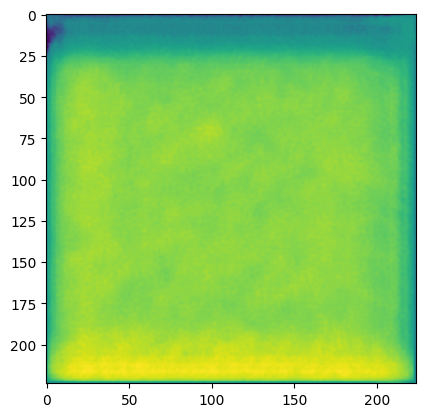

In [236]:
cellpose_model.net.eval()
image = X_train[0][0:224,0:224]
image = np.stack((image, image), axis=0)
y, style = cellpose_model.net(torch.from_numpy(image).unsqueeze(0).float().cuda())
plt.imshow(y[0,0].cpu().detach().numpy())

In [211]:
#expand the channels of image
image_2 = np.pad(image, ((0,0,1080-image.shape[0]),(0,1080-image.shape[1])), 'constant', constant_values=0)
image_2 = np.stack((image, image), axis=0)
#pad image_2 to 1080x1080

print(image_2.shape)

cellpose_model.net(torch.from_numpy(image_2).unsqueeze(0).float().cuda())

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\numpy\lib\arraypad.py:737: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pad_width = np.asarray(pad_width)


TypeError: `pad_width` must be of integral type.

In [183]:
print(flows[0])

[[[  0   2   1]
  [  0   8   5]
  [  0   6   7]
  ...
  [  4  46  81]
  [  7  30  66]
  [  3   6  20]]

 [[  4   8   0]
  [  5  21   5]
  [  0  11   8]
  ...
  [ 12  41  99]
  [ 19  31  99]
  [ 10  11  44]]

 [[  5   7   0]
  [  7  11   0]
  [  1   3   0]
  ...
  [ 14  27  81]
  [ 22  21  86]
  [ 12   9  44]]

 ...

 [[ 30  53   3]
  [ 57  97   5]
  [ 30  50   2]
  ...
  [ 82   0  79]
  [ 95   0 107]
  [ 56   1  77]]

 [[ 46  45   0]
  [ 96  85   0]
  [102  54   7]
  ...
  [122   6  72]
  [116   2  87]
  [ 53   0  52]]

 [[ 20  15   0]
  [ 65  36   4]
  [ 91  32  15]
  ...
  [ 93  11  39]
  [ 73   5  37]
  [ 22   0  15]]]


In [139]:
print(cellpose_model_net)

CPnet(
  (downsample): downsample(
    (down): Sequential(
      (res_down_0): resdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_1): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_2): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv_3): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [140]:
from os import listdir
from os.path import isfile, join

def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        files = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in files]
    
    return files

def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

images, masks = get_data("c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DH-SIM+/', set = '0102',normalise_images=True)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [141]:
print(np.unique(X_train[0]))

[0.         0.00980392 0.01960784 0.02941176 0.03921569 0.04901961
 0.05882353 0.06862745 0.07843137 0.08823529 0.09803922 0.10784314
 0.11764706 0.12745098 0.1372549  0.14705882 0.15686275 0.16666667
 0.17647059 0.18627451 0.19607843 0.20588235 0.21568627 0.2254902
 0.23529412 0.24509804 0.25490196 0.26470588 0.2745098  0.28431373
 0.29411765 0.30392157 0.31372549 0.32352941 0.33333333 0.34313725
 0.35294118 0.3627451  0.37254902 0.38235294 0.39215686 0.40196078
 0.41176471 0.42156863 0.43137255 0.44117647 0.45098039 0.46078431
 0.47058824 0.48039216 0.49019608 0.5        0.50980392 0.51960784
 0.52941176 0.53921569 0.54901961 0.55882353 0.56862745 0.57843137
 0.58823529 0.59803922 0.60784314 0.61764706 0.62745098 0.6372549
 0.64705882 0.65686275 0.66666667 0.67647059 0.68627451 0.69607843
 0.70588235 0.71568627 0.7254902  0.73529412 0.74509804 0.75490196
 0.76470588 0.7745098  0.78431373 0.79411765 0.80392157 0.81372549
 0.82352941 0.83333333 0.85294118 0.8627451  0.87254902 0.882352

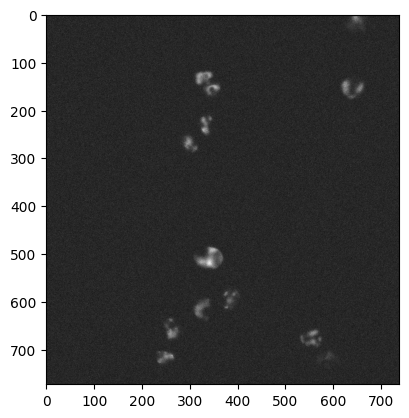

In [65]:
plt.imshow(X_train[0], cmap='gray')

In [160]:
#predict on X_train[0]
image = X_train[8]
#get a 224 x 224 crop
image = image[0:224,0:224]
#make it have 2 channels
image = np.stack((image, image), axis=0)
image = torch.from_numpy(image)
image = image.unsqueeze(0)
image = image.to('cuda:0')
image = image.float()
print(image.shape)

pred0, pred1 = cellpose_model_net(image)
print(pred0.shape)
print(pred1.shape)
pred0 = pred0.detach().cpu().numpy()

torch.Size([1, 2, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 256])


[[ 0.74262404  0.8899894   0.90565753 ... -0.9771857  -0.6697972
  -0.6020043 ]
 [ 0.7911213   0.9228905   0.887887   ... -0.7708284  -0.5501718
  -0.5120483 ]
 [ 0.6209809   0.7531662   0.61192375 ... -0.7006316  -0.589987
  -0.4100521 ]
 ...
 [-2.828337   -3.3863585  -4.2930226  ... -2.466759   -2.3841908
  -1.7215961 ]
 [-2.4185162  -2.9216535  -3.2949362  ... -2.6389399  -2.2902129
  -1.6766385 ]
 [-2.3552191  -2.3326066  -2.4633987  ... -2.5021503  -2.3292365
  -2.0131898 ]]


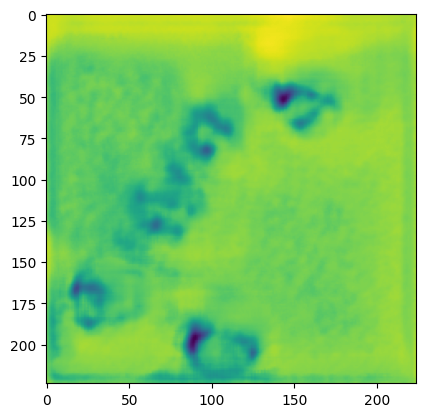

In [158]:
pred0_mean = np.mean(pred0, axis=1, keepdims=True).squeeze()
plt.imshow(pred0_mean)

print(pred0_mean)

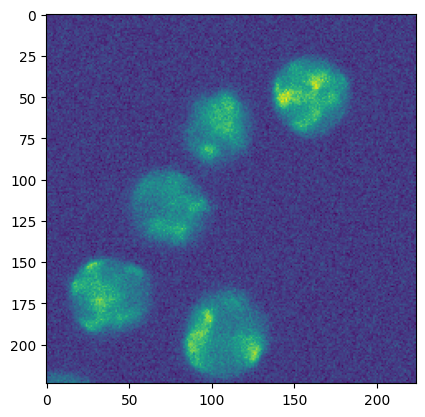

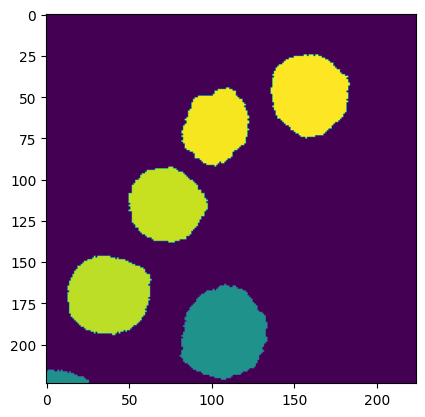

(1, 2, 224, 224)


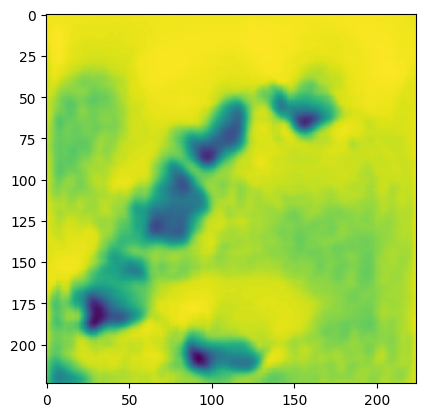

(array([False,  True]), array([ 1766, 48410], dtype=int64))


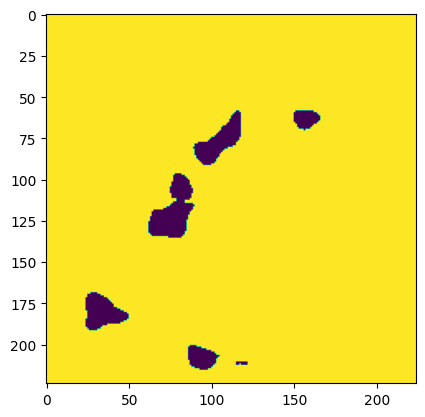

In [137]:
image = X_train[8]
image = image[0:224,0:224]
plt.imshow(image)
plt.show()
plt.imshow(y_train[8][0:224,0:224])
plt.show()
#make it have 2 channels
image = np.stack((image, image), axis=0)
image = np.expand_dims(image, axis=0)
print(image.shape)
masks, flows, styles = cellpose_model.eval(image)
plt.imshow(flows[2][0:224,0:224])
plt.show()

normalised =  (flows[2]-np.min(flows[2]))/(np.max(flows[2])-np.min(flows[2]))
plt.imshow(np.where(normalised>0.4,1,0))
print(np.unique(normalised[0:224,0:224]>0.4,return_counts=True))

(array([-79.48355  , -79.30479  , -78.956894 , ...,   3.8583016,
         3.8840795,   3.9143777], dtype=float32), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))


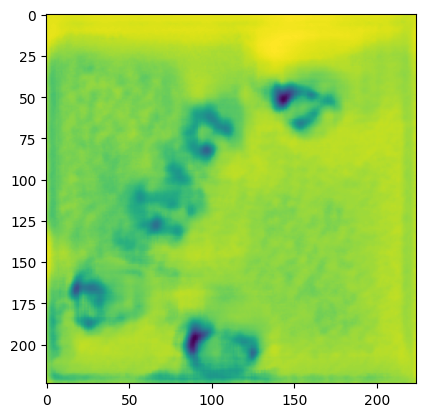

In [135]:
pred0_first_channel = pred0[0,2,:,:]
pred0_first_channel_sigmoided = torch.sigmoid(pred0_first_channel)
pred0_first_channel_bin = pred0_first_channel_sigmoided > 0.4
print(np.unique(pred0_first_channel.cpu().detach().numpy(),return_counts=True))
plt.imshow(pred0_first_channel.cpu().detach().numpy())

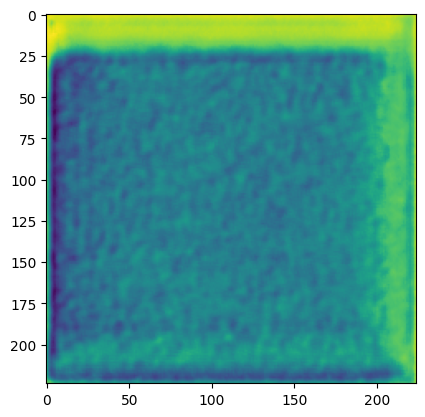

In [90]:
import matplotlib.pyplot as plt

plt.imshow(pred0[0,2,:,:].cpu().detach().numpy())

In [20]:
#import the distilled model
from u_net import UNet

#load the model
model = UNet()
model = model.to('cuda:0')
model.load_state_dict(torch.load('train_dir/models/distillation_model_SIM_1'))

with torch.cuda.device(0):
  net = model
  macs, params = get_model_complexity_info(net, (1, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

UNet(
  116.75 k, 100.000% Params, 1.38 GMac, 100.000% MACs, 
  (encoder): Encoder(
    71.79 k, 61.490% Params, 475.27 MMac, 34.437% MACs, 
    (encBlocks): ModuleList(
      71.79 k, 61.490% Params, 473.86 MMac, 34.336% MACs, 
      (0): Block(
        2.48 k, 2.124% Params, 125.24 MMac, 9.075% MACs, 
        (conv1): Conv2d(160, 0.137% Params, 8.03 MMac, 0.582% MACs, 1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(0, 0.000% Params, 802.82 KMac, 0.058% MACs, )
        (conv2): Conv2d(2.32 k, 1.987% Params, 116.41 MMac, 8.435% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        13.89 k, 11.895% Params, 174.61 MMac, 12.652% MACs, 
        (conv1): Conv2d(4.64 k, 3.974% Params, 58.2 MMac, 4.217% MACs, 16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(0, 0.000% Params, 401.41 KMac, 0.029% MACs, )
        (conv2): Conv2d(9.25 k, 7.921% Params, 116.01 MMac, 8.406% MACs, 32, 32, kerne

In [22]:
print(type(params))

<class 'str'>
